# setup and imports

In [2]:
import fnmatch
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import interactive
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [3]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 34 rats in the data folder


In [4]:

animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

results = np.zeros((len(animalList), 8))
for i, animal in enumerate(animalList):
    for j, (sessionList, cond) in enumerate(zip([dist60, dist90, dist120, TM20, TM10, TM2+TMrev2, TMrev10, TMrev20], 
                                 ['dist60', 'dist90', 'dist120', 'TM20', 'TM10', 'TM2', 'TMrev10', 'TMrev20'])):
        results[i, j] = len(matchsession(animal, sessionList))
df = pd.DataFrame(results, columns=['dist60', 'dist90', 'dist120', 'TM20', 'TM10', 'TM2', 'TMrev10', 'TMrev20'], index=animalList)
average_sessions_by_rat = np.mean(results, axis=1)
average_sessions_by_cond = np.mean(results, axis=0)

total_sessions = np.sum(results)
expected_sessions = len(animalList) * 6 * 8
print(f'Total sessions: {total_sessions}')
print(f'Expected sessions: {expected_sessions}')
print(f'Ratio sessions OK: {total_sessions/expected_sessions*100:.2f}%')
print(f'Ratio sessions NOOK: {(expected_sessions-total_sessions)/expected_sessions*100:.2f}%')

print(df)

Total sessions: 1314.0
Expected sessions: 1344
Ratio sessions OK: 97.77%
Ratio sessions NOOK: 2.23%
        dist60  dist90  dist120  TM20  TM10  TM2  TMrev10  TMrev20
RatF00     5.0     6.0      6.0   6.0   6.0  6.0      6.0      6.0
RatF01     5.0     6.0      6.0   6.0   6.0  6.0      6.0      6.0
RatF02     6.0     6.0      6.0   6.0   6.0  6.0      6.0      6.0
RatM00     6.0     6.0      6.0   6.0   6.0  6.0      6.0      6.0
RatM01     6.0     6.0      6.0   6.0   6.0  6.0      6.0      6.0
RatM02     6.0     6.0      6.0   6.0   6.0  6.0      5.0      6.0
RatF30     6.0     6.0      6.0   5.0   6.0  6.0      6.0      6.0
RatF31     6.0     6.0      6.0   6.0   6.0  6.0      6.0      6.0
RatF32     6.0     6.0      6.0   6.0   6.0  6.0      6.0      6.0
RatF33     6.0     6.0      6.0   6.0   6.0  6.0      6.0      6.0
RatM30     6.0     6.0      6.0   6.0   6.0  6.0      6.0      6.0
RatM31     6.0     6.0      6.0   6.0   6.0  6.0      6.0      6.0
RatM32     6.0     6.0      6

In [5]:
# INTACT RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 
            'RatM53', 'RatM54']


In [6]:
for animal in animalList:
    print(matchsession(animal, dist120)[-3])

RatF00_2021_07_22_16_11_45
RatF01_2021_07_22_17_13_24
RatF02_2021_07_22_18_14_16
RatM00_2021_07_22_16_13_03
RatM01_2021_07_22_17_14_48
RatM02_2021_07_22_18_15_36
RatF32_2022_11_26_16_59_17
RatF33_2022_11_26_18_01_54
RatM31_2022_11_26_15_57_24
RatM32_2022_11_26_16_58_02
RatF42_2023_04_23_16_51_22
RatM40_2023_04_23_14_46_06
RatM43_2023_04_23_17_51_40
RatM53_2023_08_02_17_56_54
RatM54_2023_08_02_17_57_50


In [7]:
animal='RatM00'
session='RatM00_2021_07_22_16_13_03'

In [8]:
# for animal in animalList:
#     print(matchsession(animal, dist120)[-3])
#     fig, axs = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'width_ratios': [3, 1]})
#     # for i in range(6):
#     i= -3
#     Figure1B(animal=animal, session=matchsession(animal, dist120)[i], ax=axs[0])
#     Figure1D(animal=animal, session=matchsession(animal, dist120)[i], ax=axs[1])

# 1A schematic

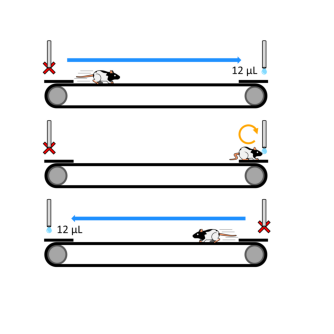

In [9]:
def Figure1A(ax=None, path=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    if path is None:
        path = "/home/david/Desktop/code/Figures/1A.png"

    try:
        img = plt.imread(path)
        ax.imshow(img)
    except FileNotFoundError:
        print("Image not found")
    ax.axis("off")

fig, ax = plt.subplots(1, 1, figsize=(1, 1))
Figure1A(ax=ax)

# 1B full track

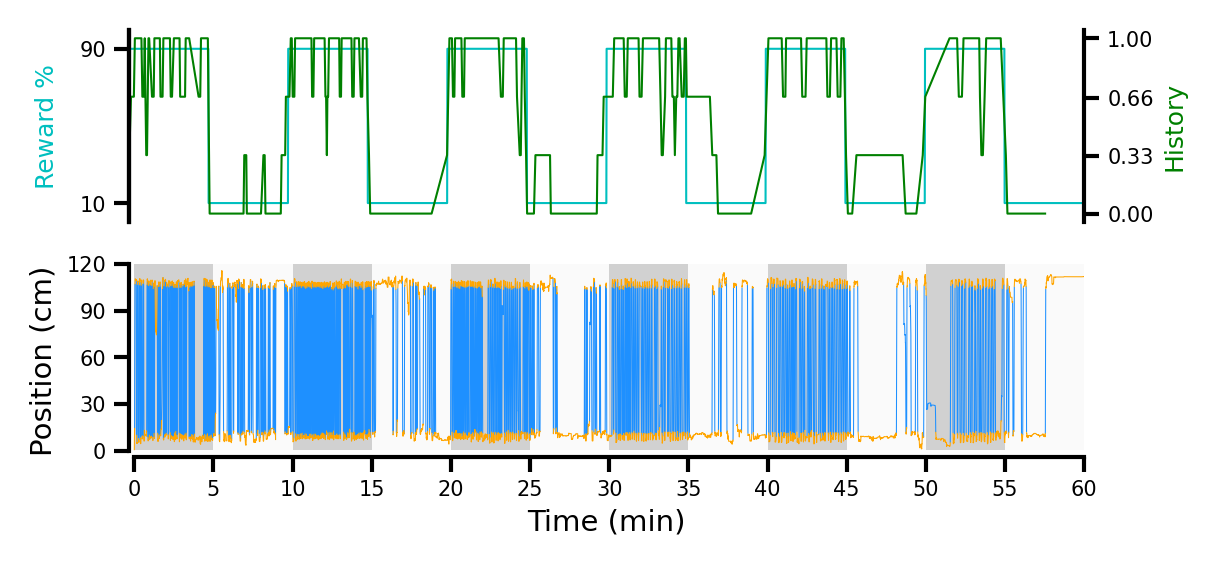

In [10]:
# plot session track without analysis files, session 120cm
def Figure1B(root="/home/david/Desktop/ALLDATA", 
            animal='RatM00', session='RatM00_2021_07_22_16_13_03', 
            ax=None):
    '''
    read position file and plot animal trajectory
    '''
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize = (cm2inch(10), cm2inch(4.5)))

    params = get_from_pickle(root, animal, session, name="params.p")
    time = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[3])[:90000]
    pos  = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[4])[:90000]/11
    mask = stitch([get_from_pickle(root, animal, session, name="mask.p")])[0]   
    pos = smooth(pos.astype('float32'), 2)

    running_Xs = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(pos, mask)]]
    idle_Xs = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(pos, mask)]]

    for i in range(0, len(params['blocks'])):
        ax.axvspan(params['blocks'][i][0], params['blocks'][i][1], ymin=1/30, ymax=1,
                    color='grey', alpha=params['rewardProbaBlock'][i]/250, linewidth=0)

    ax.plot(time, running_Xs, color="dodgerblue", lw=.25)
    ax.plot(time, idle_Xs, color="orange", lw=.25)

    ax.set_xlim(0, 3600)
    ax.set_ylim(0, 120)
    ax.set_xticks(np.arange(0, 3601, 300))
    ax.set_xticklabels(np.arange(0, 61, 5))
    ax.set_yticks(np.arange(0, 121, 30))
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Position (cm)")
    space_axes(ax, x_ratio_right=0, x_ratio_left=1/180)




def Figure1Bbis(root="/home/david/Desktop/ALLDATA", 
            animal='RatM00', session='RatM00_2021_07_22_16_13_03', 
            ax=None):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    params = get_from_pickle(root, animal, session, name="params.p")
    seq = get_from_pickle(root, animal, session, name="sequence.p")

    time = np.arange(0, 3600, 1)
    rewardProba = np.ones(3600)

    for t in range(0, len(time)):
        for i in range(0, len(params['blocks'])):
            if time[t] in range(params['blocks'][i][0], params['blocks'][i][1]):
                rewardProba[t] *= params['rewardProbaBlock'][i]

    ax.plot(time, rewardProba, color='c', lw=.5)

    time_of_reward = []
    received_reward = []
    for elem in seq:
        if seq[elem][1] == 'run':
            time_of_reward.append(seq[elem][0])
            received_reward.append(seq[elem][2])

    ax2 = ax.twinx()
    # turn ax 2 frame on
    ax2.spines['right'].set_visible(True)
    ax2.spines['bottom'].set_visible(False)
    ax2.set_ylim(-0.05, 1.05)
    ax2.set_yticks([0, 0.33, 0.66, 1])
    ax2.set_ylabel('History', color='g', fontsize=6)
    ax2.plot(time_of_reward, movinavg(received_reward, 3), 'g', lw=.5)

    ax.set_xlim(0, 3600)
    ax.set_ylim(0, 100)
    ax.set_yticks([10, 90])
    ax.set_yticklabels(["10", "90"])
    ax.set_ylabel("Reward %", labelpad=5, fontsize=6, color='c')
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


fig, axs = plt.subplots(2, 1, figsize = (cm2inch(10), cm2inch(4.5)))
Figure1B(ax=axs[1], root=root)
Figure1Bbis(ax=axs[0], root=root)

# 1C ZOOM

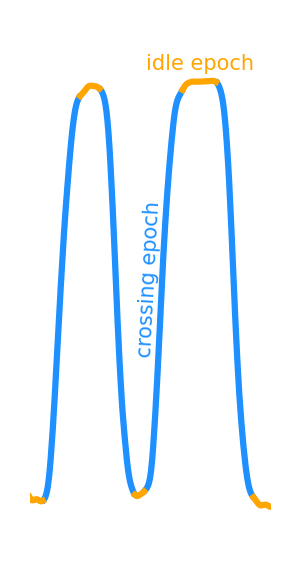

In [11]:
def Figure1C(root="/home/david/Desktop/ALLDATA", 
            animal='RatF02', session='RatF02_2021_07_22_18_14_16', 
            ax=None):
    '''
    read position file and plot animal trajectory
    '''
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    params = get_from_pickle(root, animal, session, name="params.p")
    time = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[3])[:90000]
    pos  = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[4])[:90000]/11
    mask = stitch([get_from_pickle(root, animal, session, name="mask.p")])[0]   
    pos = smooth(pos.astype('float32'), 2)

    running_Xs = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(pos, mask)]]
    idle_Xs = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(pos, mask)]]

    ax.plot(time, running_Xs, label="run", color="dodgerblue", lw=1.5)
    ax.plot(time, idle_Xs, label="wait", color="orange", lw=1.5)

    ax.text(751.2, 112, 'idle epoch', ha="center", va="center", rotation=0, size=5, color='orange')
    ax.text(749.2, 61, 'crossing epoch', ha="center", va="center", rotation=87, size=5, color='dodgerblue')


    ax.set_xlim(744.5, 754)
    ax.set_ylim(0, 120)
    ax.axis('off')

fig, ax = plt.subplots(1, 1, figsize = (cm2inch(2.25), cm2inch(4.5)))
Figure1C(ax=ax, root=root)

# 1D Run time 1 animal 

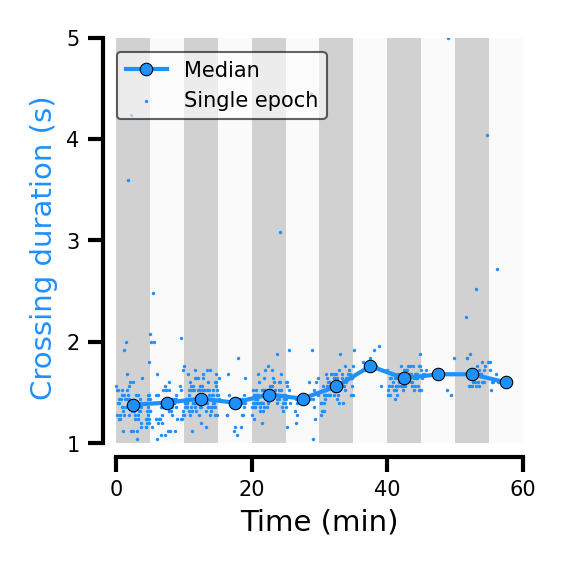

In [12]:
# plot variable median/mean fir each block
def Figure1D(root="/home/david/Desktop/ALLDATA", 
             animal='RatM00', session='RatM00_2021_07_22_16_13_03', 
             ax=None):
    
    warnings.simplefilter("ignore", category=RuntimeWarning)
    if ax is None:
        ax = plt.gca()

    params = get_from_pickle(root, animal, session, name="params.p")
    blocks = params['blocks']
    rewardProbaBlock = params['rewardProbaBlock']
    example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")
    data = [example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)]

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
        # ax.scatter(np.random.normal(((blocks[i][1] + blocks[i][0])/120), .75, len(data[i])), data[i], s=.15, color='dodgerblue', zorder=3, linewidth=.5, edgecolor='dodgerblue')

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
            [np.median(data[i]) for i in range(0, len(blocks))],  # or use median
            marker='o', ms=3, color='dodgerblue', 
            zorder=4, markeredgecolor='k', markeredgewidth=0.25, label='Median')


    ax.set_xlim(0, 60)
    ax.set_xlabel("Time (min)")

    ax.set_ylim(1, 5)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_ylabel("Crossing duration (s)", color='dodgerblue')


    _x, _y = [], []
    sequence = get_from_pickle(root, animal, session, name="sequence.p")
    for elem in sequence: 
        if sequence[elem][1]=='run':
            _x.append(sequence[elem][0]/60)
            _y.append(sequence[elem][3])

    ax.scatter(_x, _y, marker='o', s=.1, color='dodgerblue', zorder=3, linewidth=.5, edgecolor='dodgerblue', label='Single epoch')


    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize = (cm2inch(4.5), cm2inch(4.5)))
Figure1D(ax=ax, root=root)

# 1E idle time 1 animal 

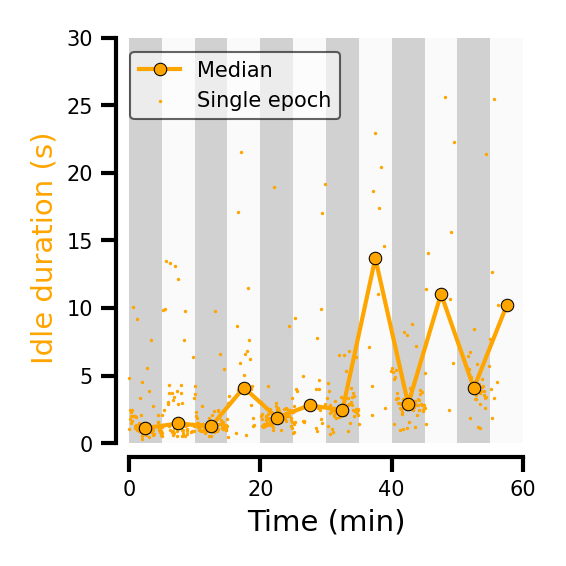

In [13]:
# plot idle time mean for each block
def Figure1E(root="/home/david/Desktop/ALLDATA", 
             animal='RatM00', session='RatM00_2021_07_22_16_13_03', 
             
             ax=None):
    
    warnings.simplefilter("ignore", category=RuntimeWarning)
    if ax is None:
        ax = plt.gca()

    params = get_from_pickle(root, animal, session, name="params.p")
    blocks = params['blocks']
    rewardProbaBlock = params['rewardProbaBlock']
    example_idleTimeInLeftBin, example_idleTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")
    data = [example_idleTimeInLeftBin[i]+example_idleTimeInRightBin[i] for i in range(0, 12)]

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
            [np.median(data[i]) for i in range(0, len(blocks))],  # or use median
            marker='o', ms=3, color='orange', 
            zorder=4, markeredgecolor='k', markeredgewidth=0.25, label='Median')

    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Idle duration (s)", color='orange')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 30)

    _x, _y = [], []
    sequence = get_from_pickle(root, animal, session, name="sequence.p")
    for elem in sequence: 
        if sequence[elem][1]=='stay':
            _x.append(sequence[elem][0]/60)
            _y.append(sequence[elem][3])

    ax.scatter(_x, _y, marker='o', s=.1, color='orange', zorder=3, linewidth=.5, edgecolor='orange', label='Single epoch')


    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)
    space_axes(ax)


fig, ax = plt.subplots(1, 1, figsize = (cm2inch(4.5), cm2inch(4.5)))
Figure1E(ax=ax, root=root)

# 1F run time all animals 



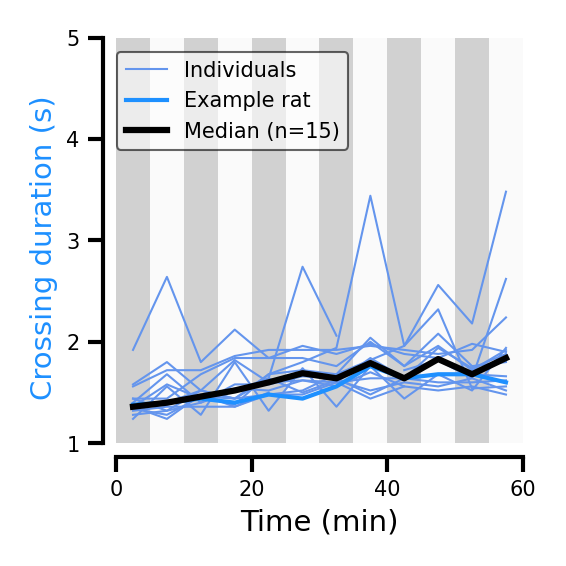

In [17]:
def Figure1F(root="/home/david/Desktop/ALLDATA", 
             sessionindex=-3, 
             ax=None):
    
    warnings.simplefilter("ignore", category=RuntimeWarning)
    if ax is None:
        ax = plt.gca()

    median_all_animals = np.empty([len(animalList), 12])
    for idx, animal in enumerate(animalList):
        session = matchsession(animal, dist120)[sessionindex]
        params = get_from_pickle(root, animal, session, name="params.p")
        blocks = params['blocks']
        rewardProbaBlock = params['rewardProbaBlock']
        example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")
        data = [example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)]

        if animal == 'RatM00':
            ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [np.median(data[i]) for i in range(0, len(blocks))],  # or use median
                # marker='o', ms=3, markeredgecolor='k', markeredgewidth=0.5, 
                color='dodgerblue', 
                zorder=4, label=f'Example rat')
        else:
            ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [np.median(data[i]) for i in range(0, len(blocks))],
                color='cornflowerblue', lw=.5,
                zorder=3, markeredgecolor='k', markeredgewidth=0.5, alpha=1,
                label=f'Individuals')
            
        median_all_animals[idx] = [np.median(data[i]) for i in range(0, len(blocks))]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            np.nanmedian(median_all_animals, axis=0),
            color='k', lw=1.5, zorder=5, markeredgecolor='k', markeredgewidth=0.25, 
            label=f'Median (n={len(animalList)})')
    
    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)

    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Crossing duration (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(1, 5)
    ax.set_yticks([1, 2, 3, 4, 5])

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)
    space_axes(ax)



fig, ax = plt.subplots(1, 1, figsize = (cm2inch(4.5), cm2inch(4.5)))
Figure1F(ax=ax, root=root)

# 1G idle time all animals 



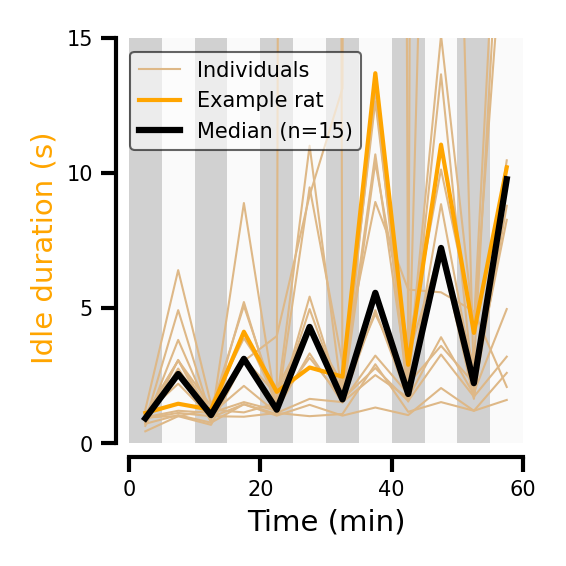

In [15]:
# plot idle time mean for each block
def Figure1G(root="/home/david/Desktop/ALLDATA", 
             sessionindex=-3, 
             ax=None):
    
    warnings.simplefilter("ignore", category=RuntimeWarning)
    if ax is None:
        ax = plt.gca()
        
    median_all_animals = np.empty([len(animalList), 12])
    for idx, animal in enumerate(animalList):
        session = matchsession(animal, dist120)[sessionindex]
        params = get_from_pickle(root, animal, session, name="params.p")
        blocks = params['blocks']
        rewardProbaBlock = params['rewardProbaBlock']

        example_idleTimeInLeftBin, example_idleTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")
        data = [example_idleTimeInLeftBin[i]+example_idleTimeInRightBin[i] for i in range(0, 12)]

        if animal == 'RatM00':
            ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [np.median(data[i]) for i in range(0, len(blocks))],  # or use median
                # marker='o', ms=3, markeredgecolor='k', markeredgewidth=0.5,
                color='orange', zorder=4, label=f'Example rat')
            
        else:
            ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [np.median(data[i]) for i in range(0, len(blocks))],
                linewidth=.5, color='burlywood', 
                zorder=3, markeredgecolor='k', markeredgewidth=0.5, alpha=1, 
                label=f'Individuals')
    
        median_all_animals[idx] = [np.median(data[i]) for i in range(0, len(blocks))]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            np.nanmedian(median_all_animals, axis=0),
            color='k', lw=1.5, zorder=5, markeredgecolor='k', markeredgewidth=0.25,
            label=f'Median (n={len(animalList)})')


    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
        
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Idle duration (s)", color='orange')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 15)
    ax.set_yticks([0, 5, 10, 15])

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize = (cm2inch(4.5), cm2inch(4.5)))
Figure1G(ax=ax, root=root)

# Figure 1

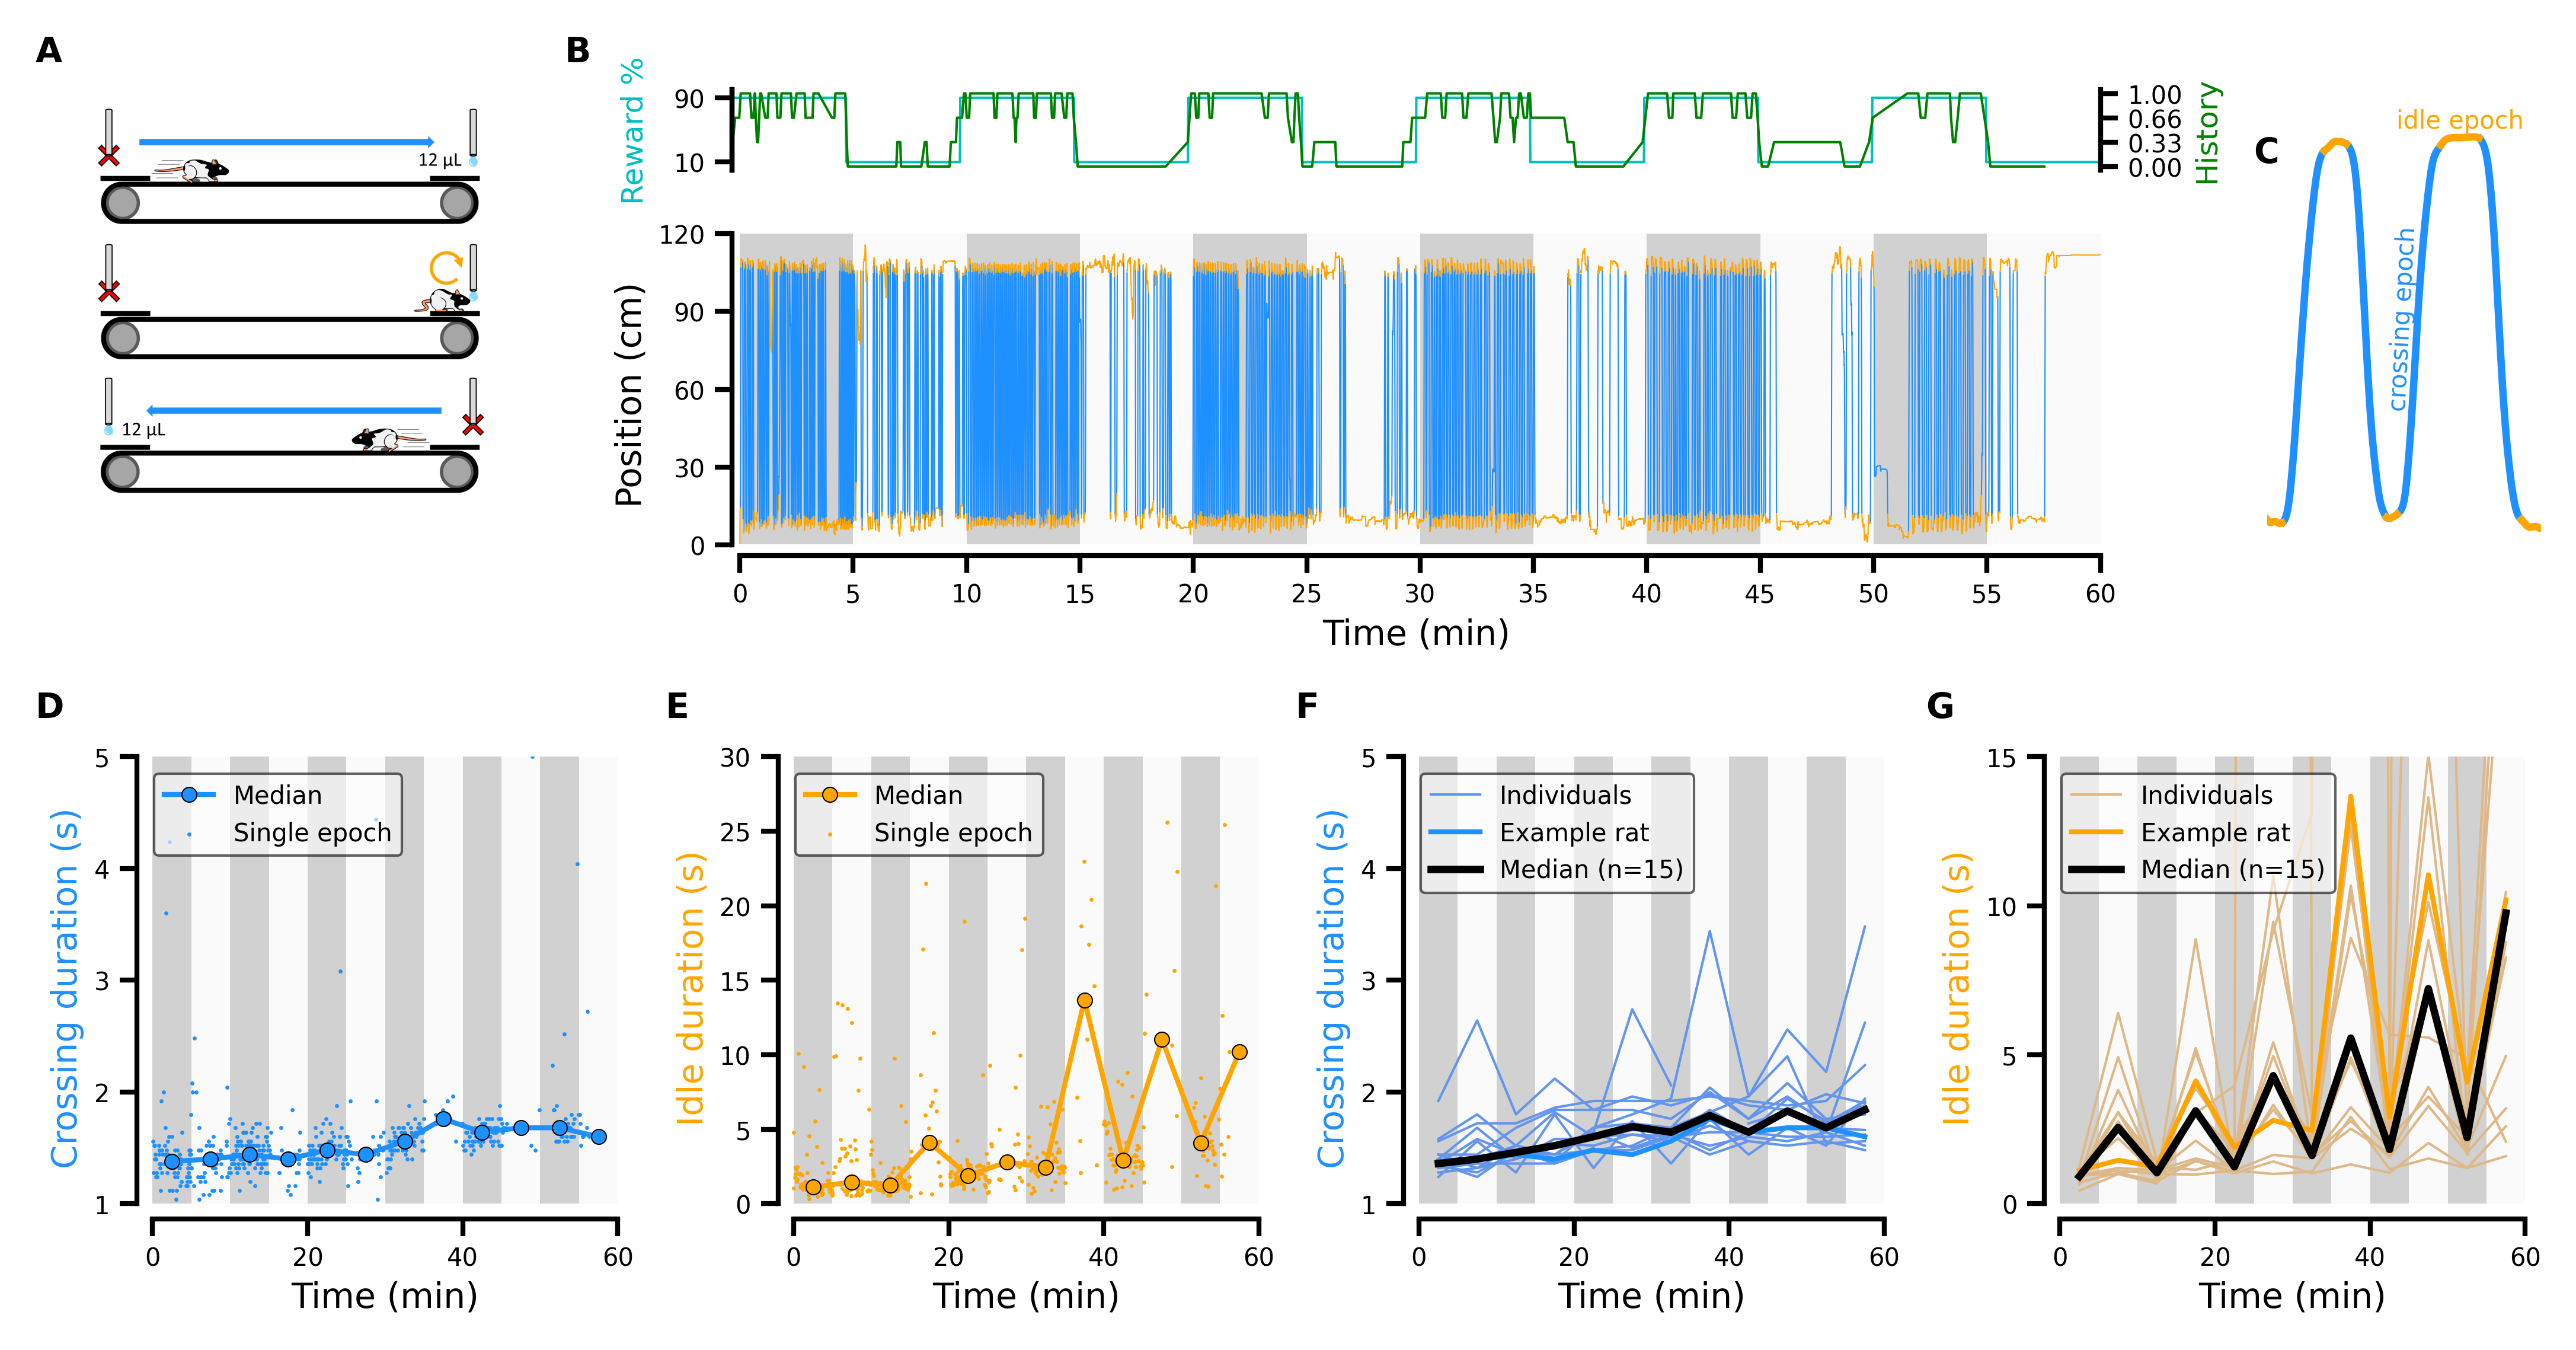

In [18]:
fig=plt.figure(figsize=(cm2inch(18), cm2inch(9)), constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(3, 1 , height_ratios=[9, 1, 9], hspace=0.5)

row1 = gs0[0].subgridspec(2, 3, height_ratios=[1, 4], width_ratios=[2, 5, 1])
setup_schematic = plt.subplot(row1[:, 0])
raw_track_track = plt.subplot(row1[1, 1])
raw_track_proba = plt.subplot(row1[0, 1])
zoom_track = plt.subplot(row1[:, -1])

row2 = gs0[2].subgridspec(1, 4, wspace=.5, width_ratios=[1, 1, 1, 1])
run_time_ex_rat = plt.subplot(row2[0, 0])
idle_time_ex_rat = plt.subplot(row2[0, 1])
run_time_all_rats = plt.subplot(row2[0, 2])
idle_time_all_rats = plt.subplot(row2[0, 3])


Figure1A(ax=setup_schematic)
Figure1B(ax=raw_track_track, root=root)
Figure1Bbis(ax=raw_track_proba, root=root)
Figure1C(ax=zoom_track, root=root)

Figure1D(ax=run_time_ex_rat, root=root)
Figure1E(ax=idle_time_ex_rat, root=root)
Figure1F(ax=run_time_all_rats, root=root)
Figure1G(ax=idle_time_all_rats, root=root)


figuresLabels={"A":[0.00, 1.00], "B":[0.21, 1.00], "C":[0.88, .92],
               "D":[0.00, 0.48], "E":[0.25, 0.48], "F":[0.50, 0.48], "G":[0.75, 0.48]}

for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1], label, figure=fig, 
             weight='bold', fontsize=7, ha='left', va='bottom')

plt.savefig("/home/david/Desktop/code/Figure_1.pdf", facecolor='w', 
                edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)